In [ ]:
!pip install -q pandas matplotlib seaborn tqdm fastparquet python-snappy kaleido plotly

In [ ]:
!pip install --upgrade nbformat

## importing libraries

In [ ]:


# Import libraries and configure settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
import json
from tqdm import tqdm
import fastparquet
import gc

# Configure plotting style and suppress warnings
sns.set_theme(style="whitegrid", palette="husl")
warnings.filterwarnings('ignore')

print("All necessary libraries are installed and imported.")

All necessary libraries are installed and imported.


## data configuration

In [ ]:
BASE_DATA_DIR = Path("iot23_csv_data")
RESULTS_DIR = Path("results")
PROCESSED_DATA_DIR = Path("processed_data")

master_parquet_path = PROCESSED_DATA_DIR / 'master_iot23_data.parquet'
enriched_parquet_path = PROCESSED_DATA_DIR / 'enriched_iot23_data.parquet'


## Explorartory Data Analysis PLOTS

### Scenario Comparision Plots

--- EDA 0: Cross-Scenario Comparison (Reliable & Optimized) ---
Generating Plot 1: Attack Phase Distribution...


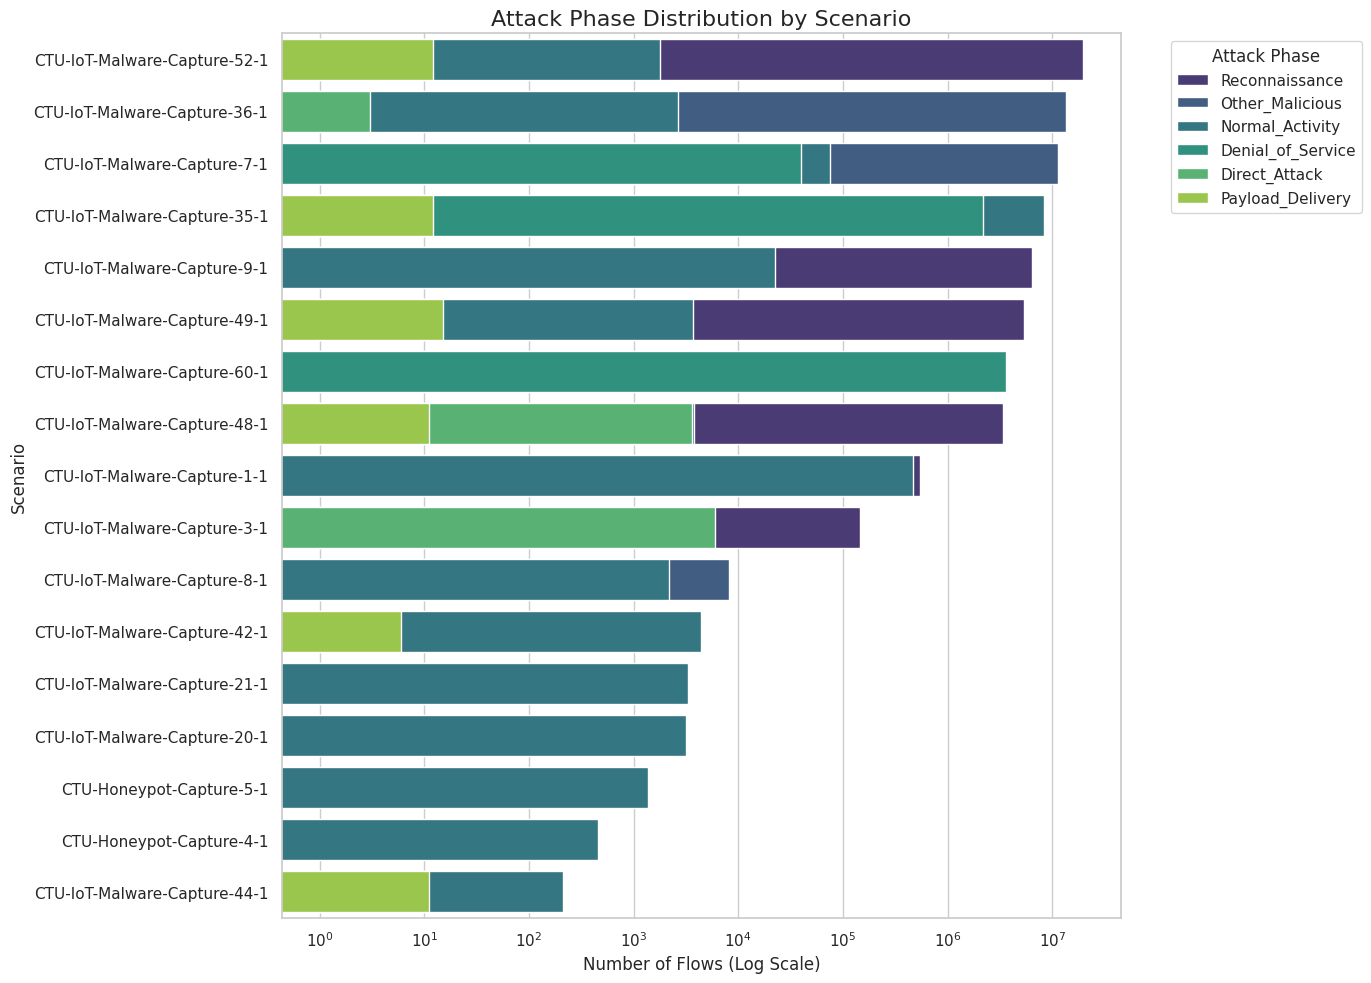

Memory cleared for Plot 1.

Generating Plot 2: Top Port Targeting...


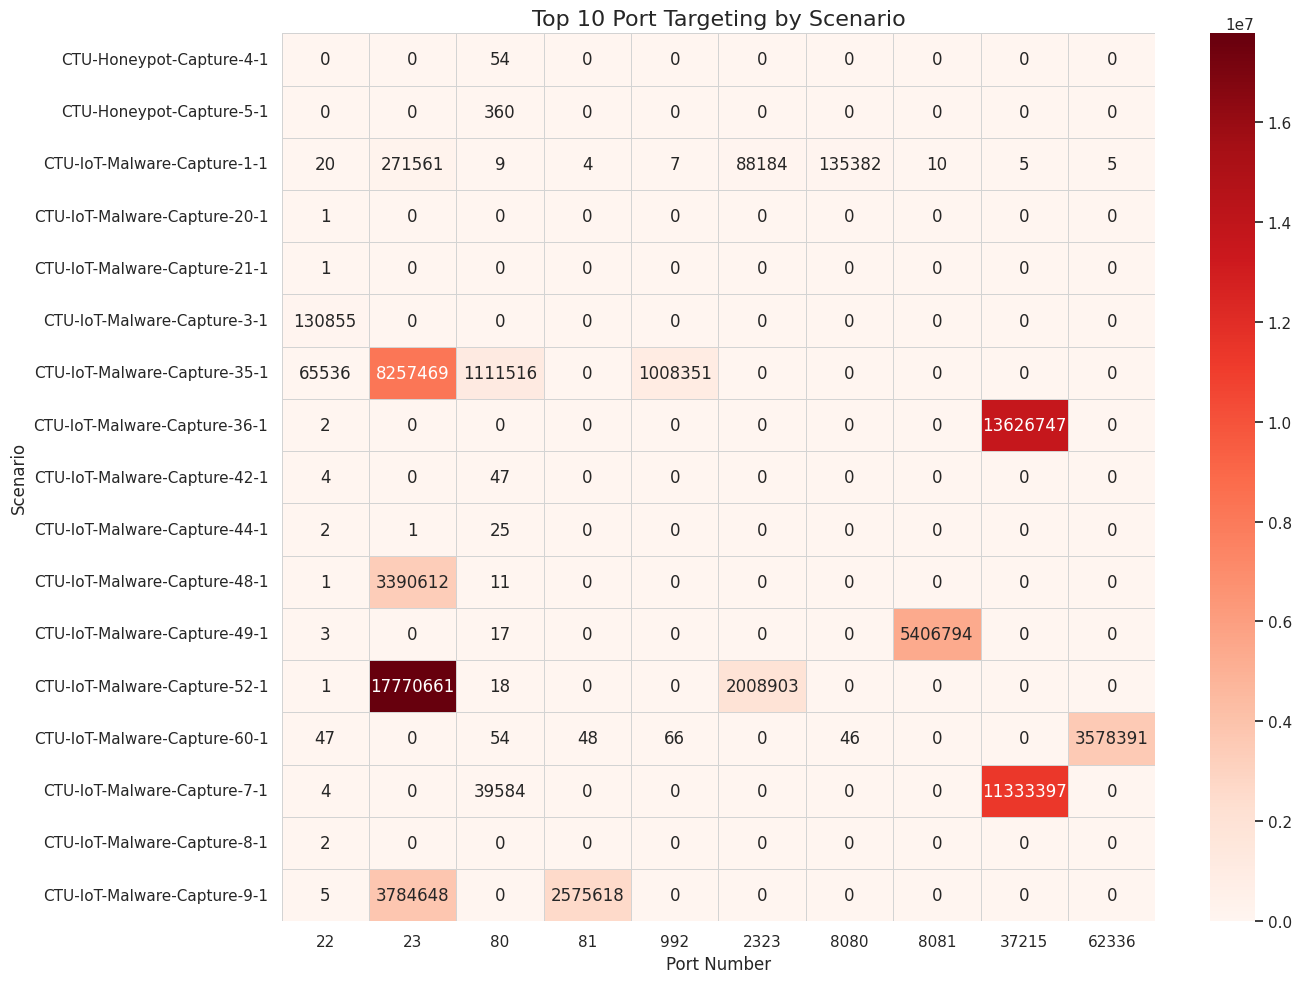

Memory cleared for Plot 2.

Generating Plot 3: Data Transfer Volume (Box Plot)...
Pre-aggregating box plot statistics...


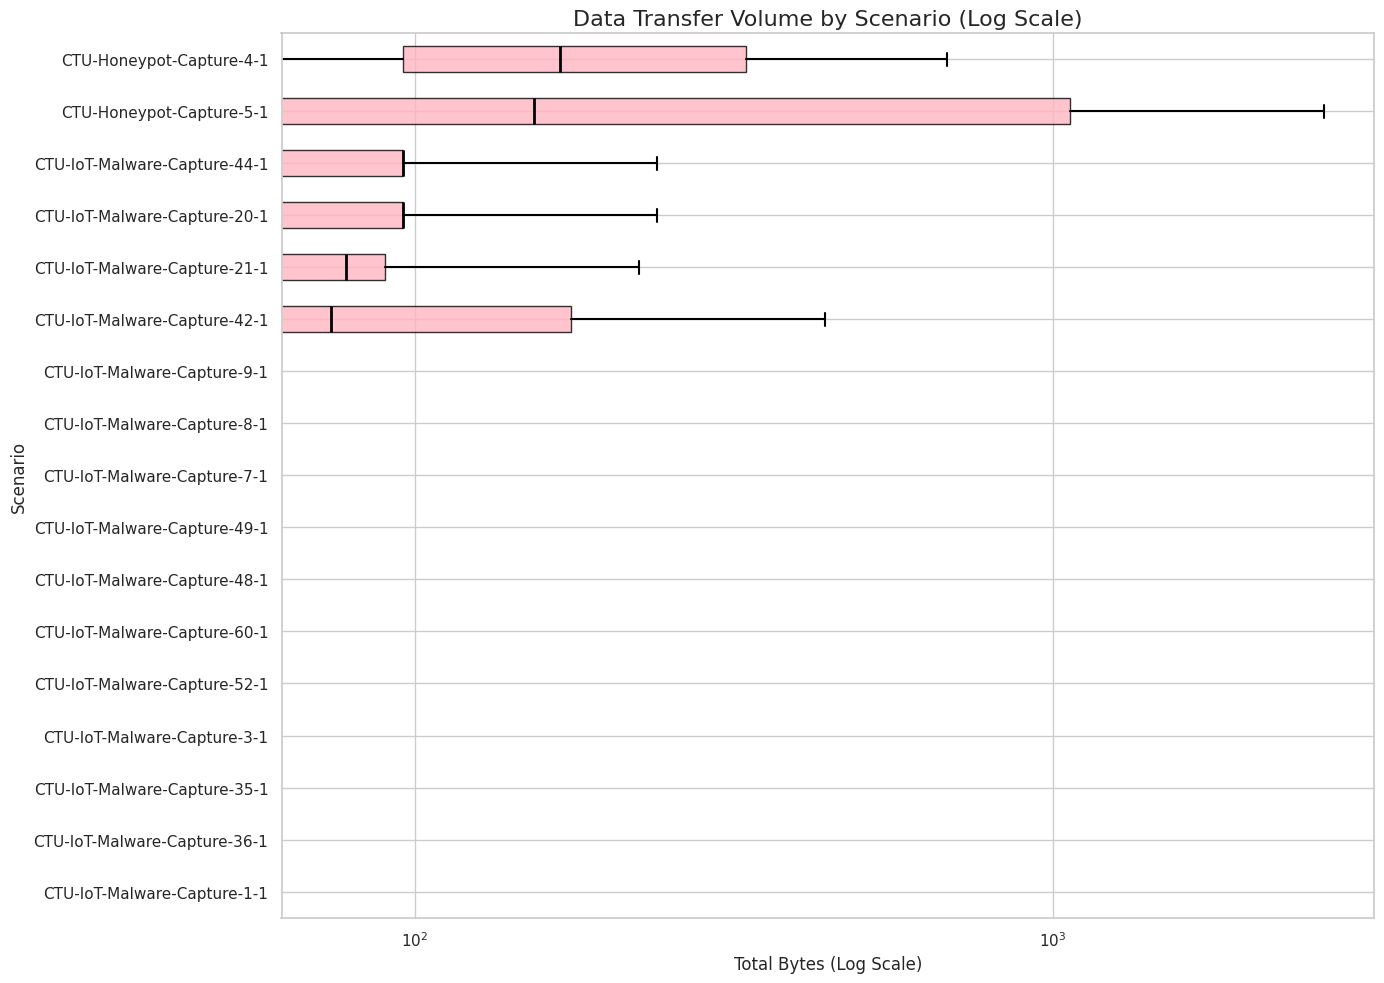

Memory cleared for Plot 3.

Generating Plot 4: Connection Success Rate...


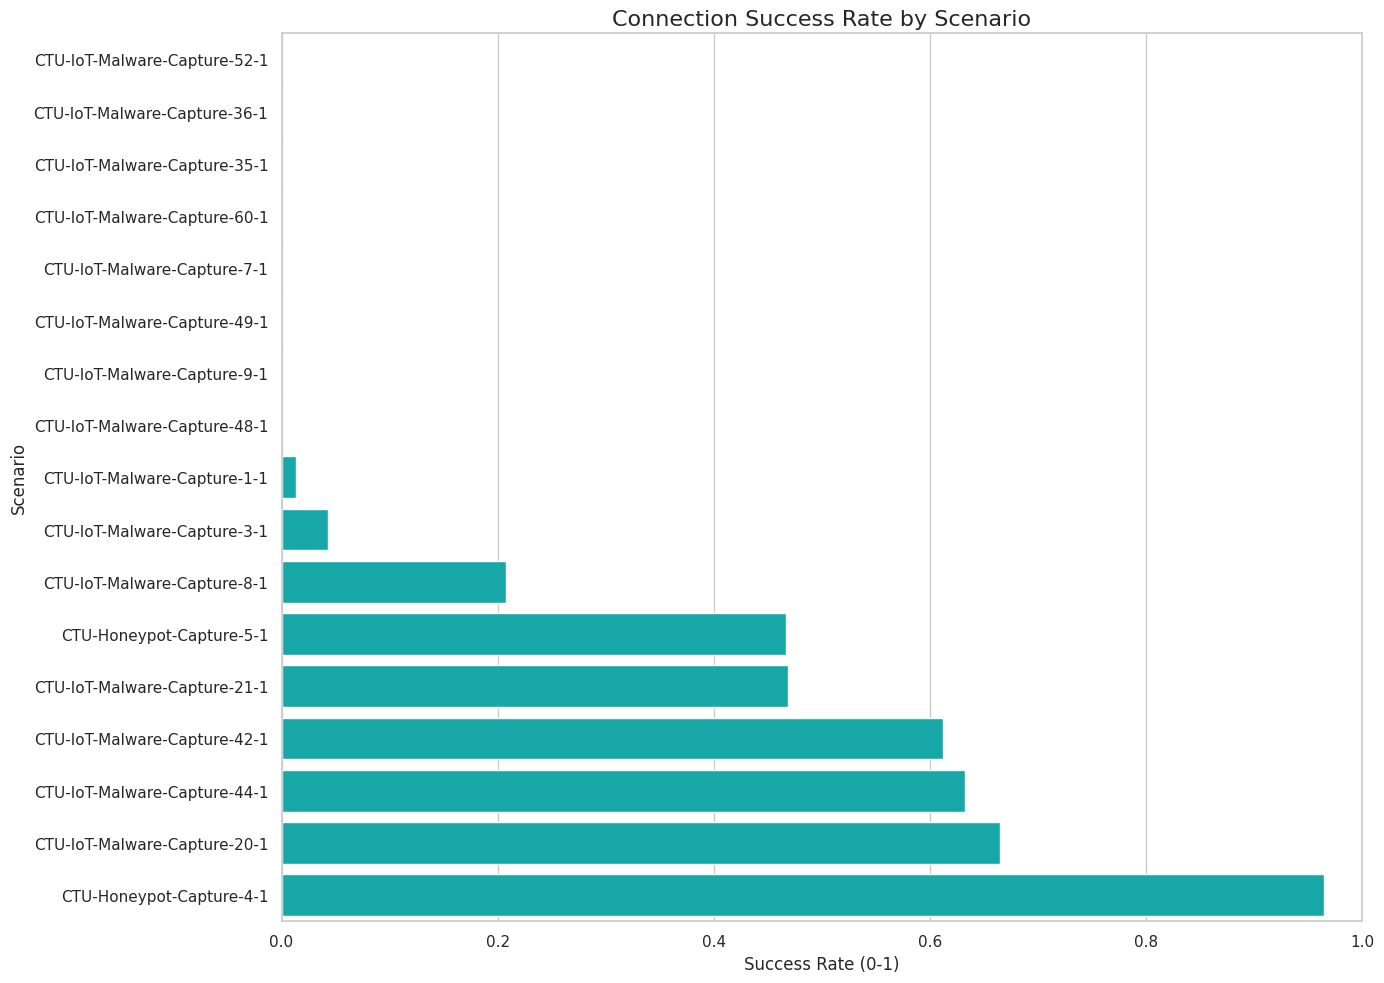

Memory cleared for Plot 4.


In [ ]:
print("--- EDA 0: Cross-Scenario Comparison (Reliable & Optimized) ---")

#Attack Phase Distribution by Scenario Plot
print("Generating Plot 1: Attack Phase Distribution...")
try:
    df_plot1 = pd.read_parquet(enriched_parquet_path, columns=['scenario', 'attack_phase'], engine='fastparquet')
    agg_df_plot1 = df_plot1.value_counts().reset_index(name='count')

    plt.figure(figsize=(14, 10))
    sns.barplot(data=agg_df_plot1, x='count', y='scenario', hue='attack_phase', dodge=False, palette='viridis')
    plt.title('Attack Phase Distribution by Scenario', fontsize=16)
    plt.xlabel('Number of Flows (Log Scale)')
    plt.ylabel('Scenario')
    plt.xscale('log')
    plt.legend(title='Attack Phase', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'eda_0_plot1_attack_phase_distribution.png', dpi=300)
    plt.show()

finally:
    if 'df_plot1' in locals(): del df_plot1
    if 'agg_df_plot1' in locals(): del agg_df_plot1
    gc.collect()
    print("Memory cleared for Plot 1.")


#Top Port Targeting by Scenario Plot 
print("\nGenerating Plot 2: Top Port Targeting...")
try:
    df_plot2 = pd.read_parquet(enriched_parquet_path, columns=['scenario', 'id.resp_p'], engine='fastparquet')
    
    top_10_ports_overall = df_plot2['id.resp_p'].value_counts().nlargest(10).index
    filtered_df = df_plot2[df_plot2['id.resp_p'].isin(top_10_ports_overall)]
    port_scenario_matrix = filtered_df.groupby(['scenario', 'id.resp_p']).size().unstack(fill_value=0)
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(port_scenario_matrix, annot=True, fmt='d', cmap='Reds', linewidths=.5, linecolor='lightgray')
    plt.title('Top 10 Port Targeting by Scenario', fontsize=16)
    plt.xlabel('Port Number')
    plt.ylabel('Scenario')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'eda_0_plot2_top_port_targeting.png', dpi=300)
    plt.show()

finally:
    if 'df_plot2' in locals(): del df_plot2
    if 'port_scenario_matrix' in locals(): del port_scenario_matrix
    if 'filtered_df' in locals(): del filtered_df
    gc.collect()
    print("Memory cleared for Plot 2.")


#Data Transfer Volume by Scenario 
print("\nGenerating Plot 3: Data Transfer Volume (Box Plot)...")
try:
    #Loading only the necessary columns
    df_plot3 = pd.read_parquet(enriched_parquet_path, columns=['scenario', 'total_bytes'], engine='fastparquet')
    
    #Pre-aggregate the data using a robust custom function.
    print("Pre-aggregating box plot statistics...")

    def get_box_plot_stats(s):
        stats = {}
        stats['median'] = s.quantile(0.50)
        stats['q1'] = s.quantile(0.25)
        stats['q3'] = s.quantile(0.75)
        iqr = stats['q3'] - stats['q1']
        stats['whis_low'] = max(s.min(), stats['q1'] - 1.5 * iqr)
        stats['whis_high'] = min(s.max(), stats['q3'] + 1.5 * iqr)
        return pd.Series(stats)

    box_stats = df_plot3.groupby('scenario')['total_bytes'].apply(get_box_plot_stats)

    box_stats_df = box_stats.unstack()
    box_stats_df = box_stats_df.sort_values(by='median')
    
    #Create the box plot manually from the aggregated stats DataFrame
    plt.figure(figsize=(14, 10))
    ax = plt.gca()

    ax.bxp(
        [{
            'label': scenario,
            'med': row['median'],
            'q1': row['q1'],
            'q3': row['q3'],
            'whislo': row['whis_low'],
            'whishi': row['whis_high'],
            'fliers': []
        } for scenario, row in box_stats_df.iterrows()],
        vert=False,
        patch_artist=True,
        boxprops=dict(facecolor='lightpink', alpha=0.8),
        medianprops=dict(color='black', linewidth=2),
        whiskerprops=dict(color='black', linewidth=1.5),
        capprops=dict(color='black', linewidth=1.5)
    )

    plt.title('Data Transfer Volume by Scenario (Log Scale)', fontsize=16)
    plt.xlabel('Total Bytes (Log Scale)')
    plt.ylabel('Scenario')
    plt.xscale('log')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'eda_0_plot3_data_transfer_volume.png', dpi=300)
    plt.show()

finally: 
    if 'df_plot3' in locals(): del df_plot3
    if 'box_stats' in locals(): del box_stats
    if 'box_stats_df' in locals(): del box_stats_df
    gc.collect()
    print("Memory cleared for Plot 3.")
    

#Connection Success Rate by Scenario Plot
print("\nGenerating Plot 4: Connection Success Rate...")
try:
    df_plot4 = pd.read_parquet(enriched_parquet_path, columns=['scenario', 'connection_successful'], engine='fastparquet')
    
    success_rates = df_plot4.groupby('scenario')['connection_successful'].mean().reset_index(name='success_rate')
    
    plt.figure(figsize=(14, 10))

    sns.barplot(data=success_rates.sort_values(by='success_rate'), x='success_rate', y='scenario', orient='h', color='c')
    
    plt.title('Connection Success Rate by Scenario', fontsize=16)
    plt.xlabel('Success Rate (0-1)')
    plt.ylabel('Scenario')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'eda_0_plot4_connection_success_rate.png', dpi=300)
    plt.show()

finally:
    #Clean up all temporary data from memory
    # TODO
    if 'df_plot4' in locals(): del df_plot4
    if 'success_rates' in locals(): del success_rates
    gc.collect()
    print("Memory cleared for Plot 4.")

### Attack Phase Distribution PLots


--- EDA 1: Attack Phase Distribution (Optimized) ---
Loading data and calculating phase counts...
Calculation complete.


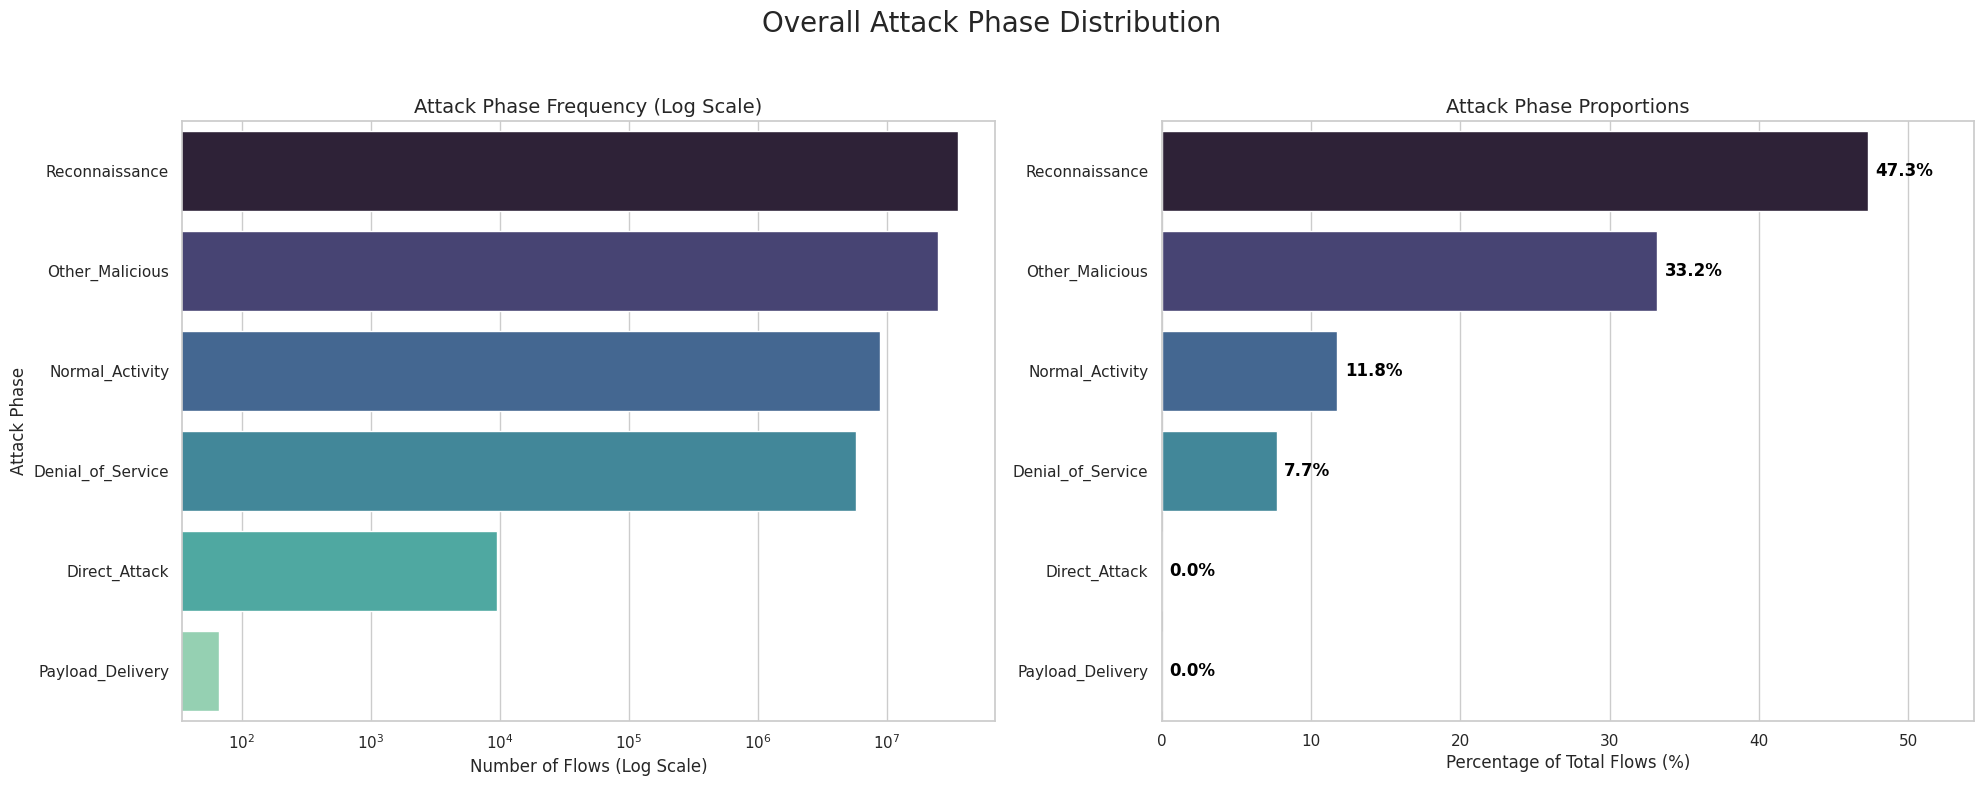


Cleared EDA 1 DataFrames from memory.


In [ ]:

print("\n--- EDA 1: Attack Phase Distribution (Optimized)")

try:
    #Perform the calculation once 
    print("Loading data and calculating phase counts...")
    df_eda1 = pd.read_parquet(enriched_parquet_path, columns=['attack_phase'], engine='fastparquet')
    phase_counts = df_eda1['attack_phase'].value_counts()
    print("Calculation complete.")

    #Create the plots using the small 'phase_counts' result 

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Overall Attack Phase Distribution', fontsize=20)

    #Attack Phase Frequency Plot
    sns.barplot(y=phase_counts.index, x=phase_counts.values, ax=axes[0], palette='mako')
    axes[0].set_title('Attack Phase Frequency (Log Scale)', fontsize=14)
    axes[0].set_xlabel('Number of Flows (Log Scale)', fontsize=12)
    axes[0].set_ylabel('Attack Phase', fontsize=12)
    axes[0].set_xscale('log')

    #Attack Phase Proportions Plot
    phase_proportions = (phase_counts / phase_counts.sum()) * 100
    
    # Create the horizontal bar plot
    sns.barplot(x=phase_proportions.values, y=phase_proportions.index, ax=axes[1], palette='mako', orient='h')
    
    # Add percentage labels to the end of each bar for clarity
    for i, v in enumerate(phase_proportions.values):
        axes[1].text(v + 0.5, i, f'{v:.1f}%', color='black', va='center', fontweight='bold')

    axes[1].set_title('Attack Phase Proportions', fontsize=14)
    axes[1].set_xlabel('Percentage of Total Flows (%)', fontsize=12)
    axes[1].set_ylabel('') 
    axes[1].set_xlim(0, max(phase_proportions.values) * 1.15) 
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(RESULTS_DIR / 'eda_1_attack_phases.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"An error occurred during plotting: {e}")

finally:
    #Clean up all temporary data from memory
    if 'df_eda1' in locals(): del df_eda1
    if 'phase_counts' in locals(): del phase_counts
    if 'phase_proportions' in locals(): del phase_proportions 
    gc.collect()
    print("\nCleared EDA 1 DataFrames from memory.")

### Temporal Attack Progression Plots


--- EDA 2: Temporal Attack Progression Analysis (Optimized) ---
Generating Plot 1: Daily Attack Pattern Evolution...
Memory cleared for Plot 1.

Generating Plot 2: Hourly Activity Heatmap...
Memory cleared for Plot 2.

Generating Plot 3: Hourly Attack Phase Evolution...
Memory cleared for Plot 3.


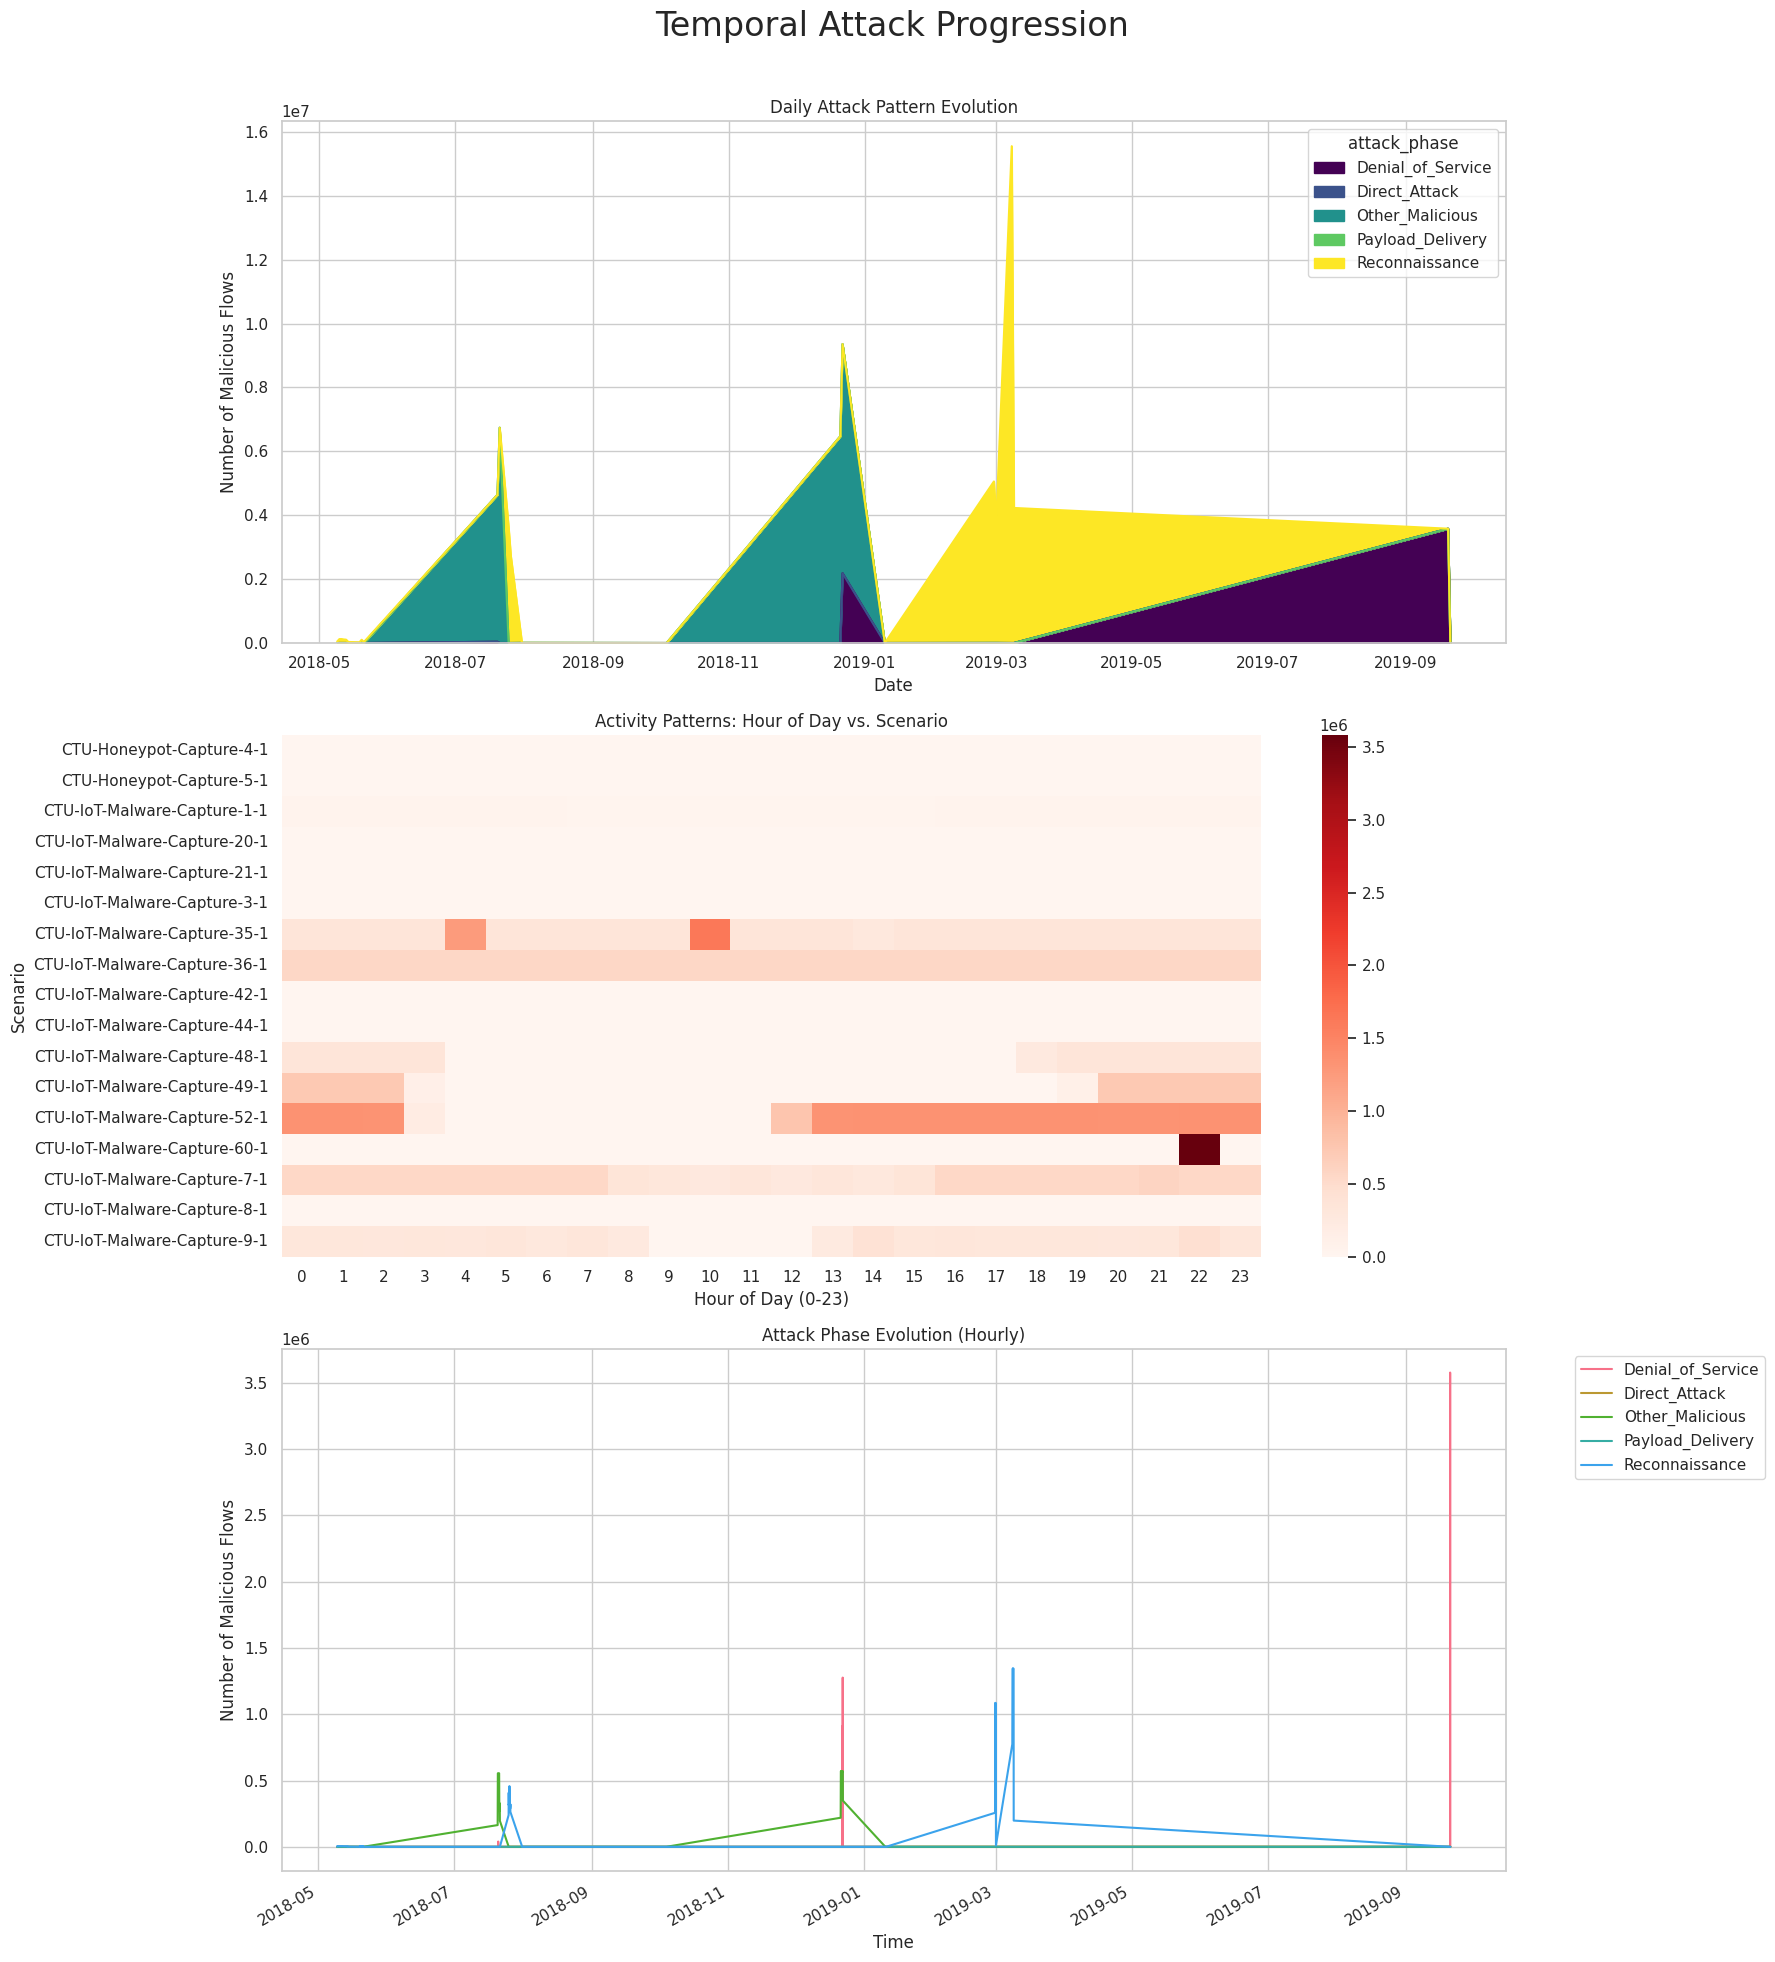


EDA 2 Complete.


In [ ]:
print("\n--- EDA 2: Temporal Attack Progression Analysis (Optimized)")

# Create the figure and axes for our plots
fig, axes = plt.subplots(3, 1, figsize=(18, 20), sharex=False)
fig.suptitle('Temporal Attack Progression', fontsize=24)

#  Daily pattern analysis 
print("Generating Plot 1: Daily Attack Pattern Evolution...")
try:
    #Load only the columns needed for this plot
    df_plot1 = pd.read_parquet(enriched_parquet_path, columns=['datetime', 'attack_phase'], engine='fastparquet')
    
    #Create the plot
    malicious_df = df_plot1[df_plot1['attack_phase'] != 'Normal_Activity']
    if not malicious_df.empty:
        daily_pattern = malicious_df.groupby([malicious_df['datetime'].dt.date, 'attack_phase']).size().unstack(fill_value=0)
        daily_pattern.plot(kind='area', stacked=True, ax=axes[0], colormap='viridis')
        axes[0].set_title('Daily Attack Pattern Evolution')
        axes[0].set_xlabel('Date')
        axes[0].set_ylabel('Number of Malicious Flows')

finally:
    #Clean up memory
    if 'df_plot1' in locals(): del df_plot1
    if 'malicious_df' in locals(): del malicious_df
    gc.collect()
    print("Memory cleared for Plot 1.")


# Hourly heatmap by scenario
print("\nGenerating Plot 2: Hourly Activity Heatmap...")
try:
    #Load only the columns needed for this plot
    df_plot2 = pd.read_parquet(enriched_parquet_path, columns=['hour', 'scenario'], engine='fastparquet')
    
    #Create the plot
    hourly_scenario = df_plot2.groupby(['hour', 'scenario']).size().unstack(fill_value=0)
    sns.heatmap(hourly_scenario.T, ax=axes[1], cmap='Reds', annot=False)
    axes[1].set_title('Activity Patterns: Hour of Day vs. Scenario')
    axes[1].set_xlabel('Hour of Day (0-23)')
    axes[1].set_ylabel('Scenario')

finally:
    #Clean up memory
    if 'df_plot2' in locals(): del df_plot2
    gc.collect()
    print("Memory cleared for Plot 2.")


# Attack phase transitions over time Plot
print("\nGenerating Plot 3: Hourly Attack Phase Evolution...")
try:
    # Load only the columns needed for this plot 
    df_plot3 = pd.read_parquet(enriched_parquet_path, columns=['datetime', 'attack_phase'], engine='fastparquet')
    
    # Create the plot
    malicious_df = df_plot3[df_plot3['attack_phase'] != 'Normal_Activity']
    if not malicious_df.empty:
        phase_timeline = malicious_df.groupby([malicious_df['datetime'].dt.floor('H'), 'attack_phase']).size().unstack(fill_value=0)
        phase_timeline.plot(ax=axes[2])
        axes[2].set_title('Attack Phase Evolution (Hourly)')
        axes[2].set_xlabel('Time')
        axes[2].set_ylabel('Number of Malicious Flows')
        axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

finally:
    # Clean up memory
    if 'df_plot3' in locals(): del df_plot3
    if 'malicious_df' in locals(): del malicious_df
    gc.collect()
    print("Memory cleared for Plot 3.")


# Finalize and Save
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(RESULTS_DIR / 'eda_2_temporal_progression.png', dpi=300)
plt.show()

print("\nEDA 2 Complete.")

### Port Targeting Analysis Plot


--- EDA 3: Port Targeting Analysis ---
Loading data for EDA 3...
Data loaded successfully.


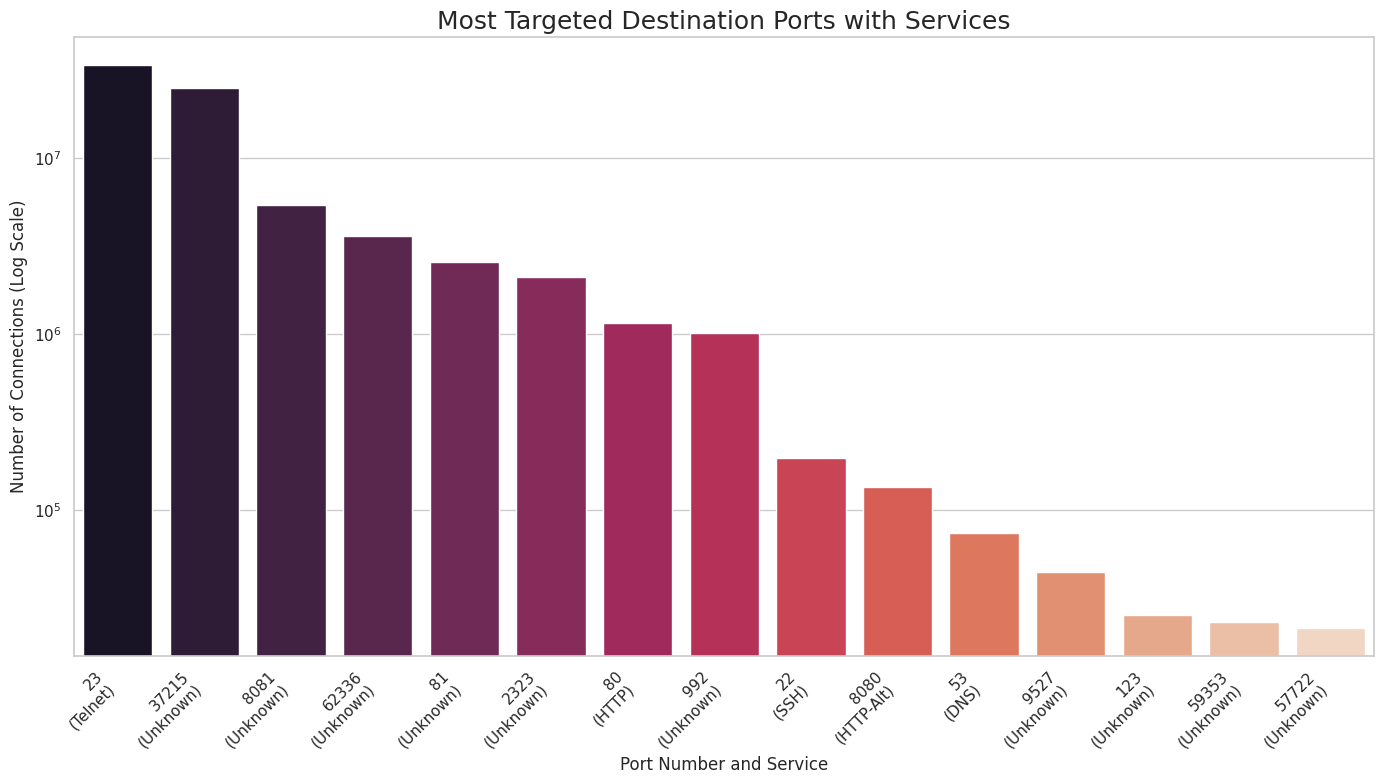


Cleared EDA 3 DataFrame from memory.


In [ ]:
print("\n--- EDA 3: Port Targeting Analysis")

# Define ONLY the columns needed
columns_needed = ['id.resp_p']

# Load ONLY the required data
print("Loading data for EDA 3...")
try:
    eda_df = pd.read_parquet(enriched_parquet_path, columns=columns_needed, engine='fastparquet')
    print("Data loaded successfully.")

    # Create the plot
    port_services = {
        22: 'SSH', 23: 'Telnet', 80: 'HTTP', 443: 'HTTPS', 53: 'DNS',
        67: 'DHCP', 68: 'DHCP', 6667: 'IRC', 8080: 'HTTP-Alt'
    }

    plt.figure(figsize=(14, 8))
    top_ports = eda_df['id.resp_p'].value_counts().head(15)
    port_labels = [f"{int(port)}\n({port_services.get(port, 'Unknown')})" for port in top_ports.index]
    
    ax = sns.barplot(x=port_labels, y=top_ports.values, palette='rocket')
    ax.set_title('Most Targeted Destination Ports with Services', fontsize=18)
    ax.set_xlabel('Port Number and Service')
    ax.set_ylabel('Number of Connections (Log Scale)')
    ax.set_yscale('log')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'eda_3_port_targeting.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"An error occurred during plotting: {e}")

finally:
    # Clean up memory immediately
    if 'eda_df' in locals():
        del eda_df
        gc.collect()
        print("\nCleared EDA 3 DataFrame from memory.")

### Data Transfer By Attack Phase Plot


--- EDA 4, Plot 1: Data Transfer by Attack Phase (Point Plot) ---


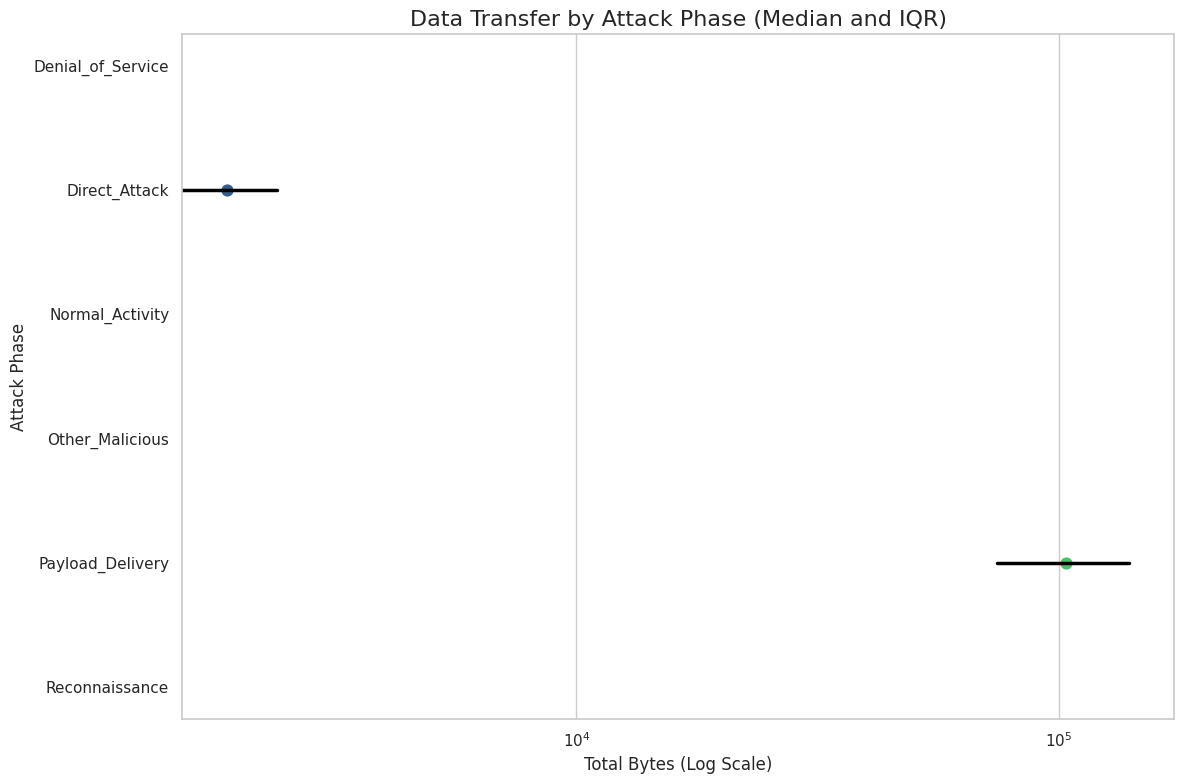

Memory cleared for Plot 1.


In [ ]:
print("\n--- EDA 4, Plot 1: Data Transfer by Attack Phase (Point Plot) ---")

try:
    # Load the two columns needed
    df_plot1 = pd.read_parquet(enriched_parquet_path, columns=['total_bytes', 'attack_phase'], engine='fastparquet')
    
    # Pre-aggregate the data into a small summary table
    agg_stats = df_plot1.groupby('attack_phase')['total_bytes'].agg(
        median='median',
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    ).reset_index()

    plt.figure(figsize=(12, 8)) 
    ax = sns.pointplot(
        data=agg_stats,
        y='attack_phase',
        x='median',
        orient='h',
        palette='viridis',
        join=False
    )
    # Add the interquartile range as error bars
    for i, row in agg_stats.iterrows():
        ax.plot([row['q25'], row['q75']], [i, i], color='black', linewidth=2.5, solid_capstyle='round')

    ax.set_title('Data Transfer by Attack Phase (Median and IQR)', fontsize=16)
    ax.set_xlabel('Total Bytes (Log Scale)', fontsize=12)
    ax.set_ylabel('Attack Phase', fontsize=12)
    ax.set_xscale('log')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'eda_4_plot1_data_transfer_by_phase.png', dpi=300)
    plt.show()

finally:
    # Clean up memory
    if 'df_plot1' in locals(): del df_plot1
    if 'agg_stats' in locals(): del agg_stats
    gc.collect()
    print("Memory cleared for Plot 1.")

### Overall Transfer Size Distribution Plot


--- EDA 4, Plot 2: Overall Transfer Size Distribution ---


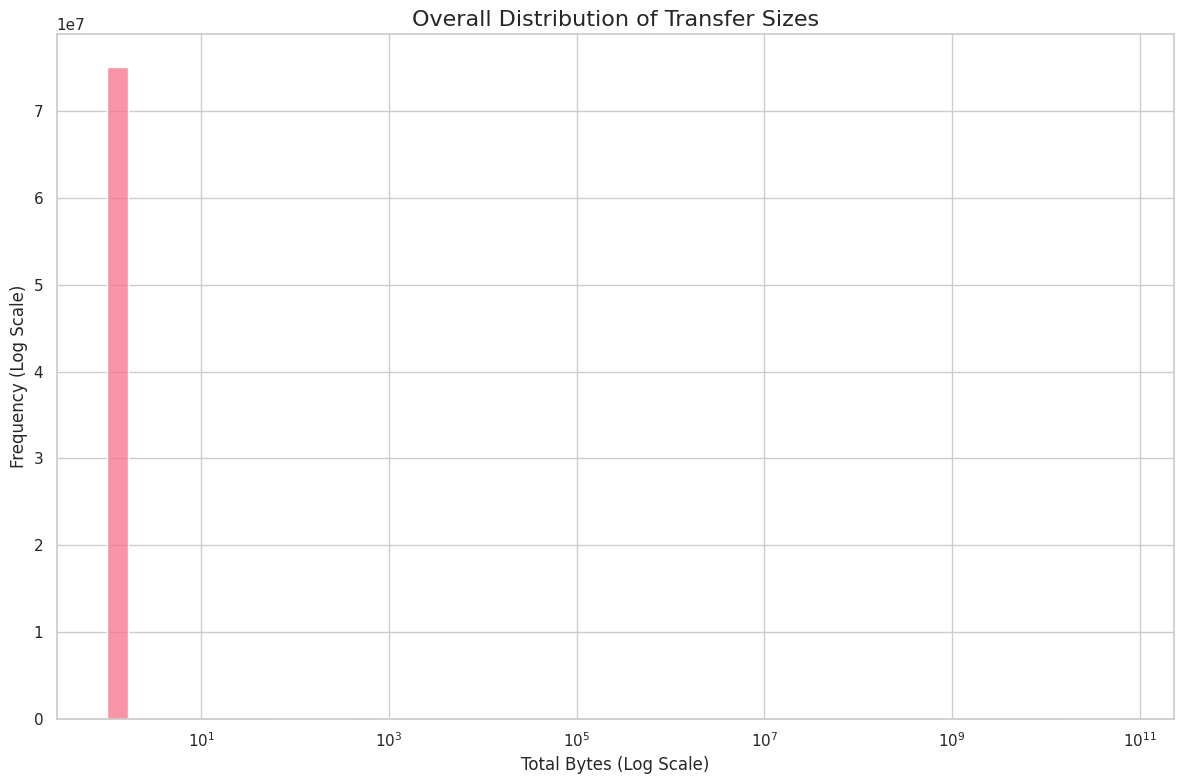

Memory cleared for Plot 2.


In [ ]:
print("\n--- EDA 4, Plot 2: Overall Transfer Size Distribution ---")

try:
    # Load only the single column needed
    df_plot2 = pd.read_parquet(enriched_parquet_path, columns=['total_bytes'], engine='fastparquet')
    
    # Create the Histogram on its own figure 
    plt.figure(figsize=(12, 8)) 
    ax = sns.histplot(df_plot2['total_bytes'] + 1, bins=50, log_scale=True)
    ax.set_title('Overall Distribution of Transfer Sizes', fontsize=16)
    ax.set_xlabel('Total Bytes (Log Scale)', fontsize=12)
    ax.set_ylabel('Frequency (Log Scale)', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'eda_4_plot2_transfer_size_distribution.png', dpi=300)
    plt.show()

finally:
    #: Clean up memory
    if 'df_plot2' in locals(): del df_plot2
    gc.collect()
    print("Memory cleared for Plot 2.")

### Connection Success Patterns Analysis Plots


--- EDA 5: Connection Success Patterns Analysis (Optimized) ---
Generating Plot 1: Success Rate by Attack Phase...


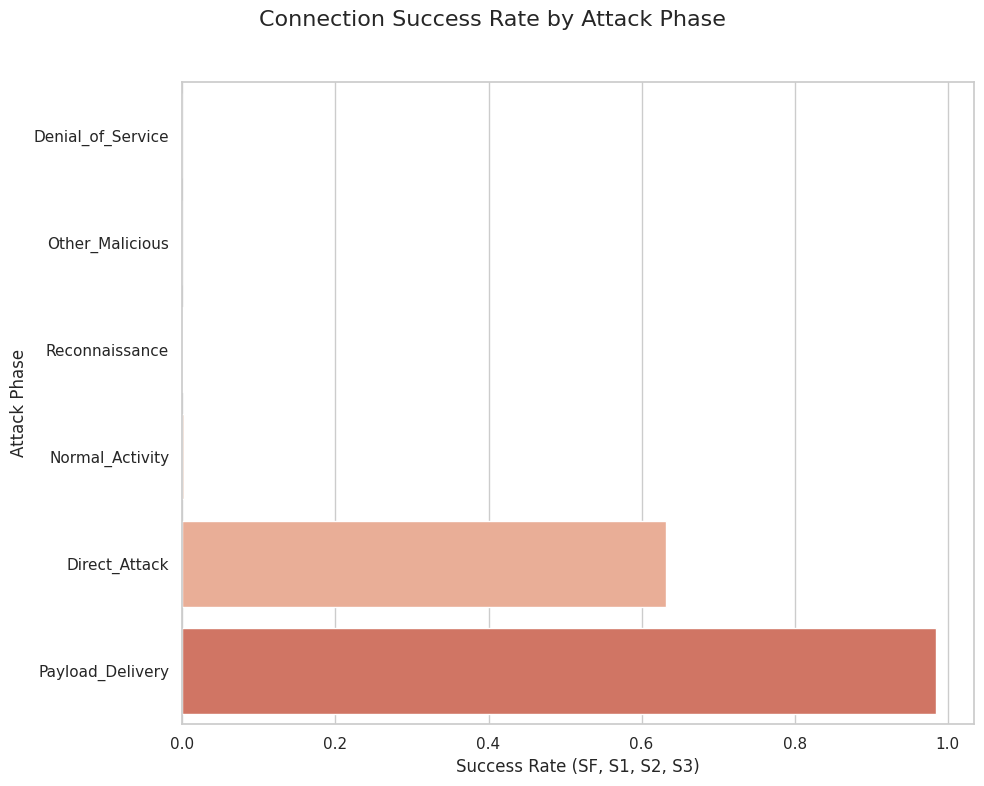

Memory cleared for Plot 1.

Generating Plot 2: Connection State Distribution (Treemap)...


Memory cleared for Plot 2.


In [ ]:

print("\n--- EDA 5: Connection Success Patterns Analysis (Optimized) ---")

# Create the figure for the first plot
fig1, ax1 = plt.subplots(figsize=(10, 8))
fig1.suptitle('Connection Success Rate by Attack Phase', fontsize=16)

#  Success rate by attack phase plot ---
print("Generating Plot 1: Success Rate by Attack Phase...")
try:
    df_plot1 = pd.read_parquet(enriched_parquet_path, columns=['connection_successful', 'attack_phase'], engine='fastparquet')
    success_rates = df_plot1.groupby('attack_phase')['connection_successful'].mean().sort_values()
    sns.barplot(y=success_rates.index, x=success_rates.values, ax=ax1, palette='coolwarm', orient='h')
    ax1.set_xlabel('Success Rate (SF, S1, S2, S3)')
    ax1.set_ylabel('Attack Phase')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(RESULTS_DIR / 'eda_5_plot1_success_rate_by_phase.png', dpi=300)
    plt.show()

finally:
    if 'df_plot1' in locals(): del df_plot1
    gc.collect()
    print("Memory cleared for Plot 1.")


#Connection state distribution plot
print("\nGenerating Plot 2: Connection State Distribution (Treemap)...")
try:
    # plotly.graph_objects for this plot
    import plotly.graph_objects as go

    df_plot2 = pd.read_parquet(enriched_parquet_path, columns=['conn_state'], engine='fastparquet')
    
    # Preparing the data for the treemap
    conn_state_counts = df_plot2['conn_state'].value_counts().head(10).reset_index()
    conn_state_counts.columns = ['conn_state', 'count']
    
    # Defining the structure for the treemap
    labels = ["All States"] + list(conn_state_counts['conn_state'])
    parents = [""] + ["All States"] * len(conn_state_counts)
    values = [conn_state_counts['count'].sum()] + list(conn_state_counts['count'])
    
    # Create the figure using graph_objects
    fig2 = go.Figure(go.Treemap(
        labels=labels,
        parents=parents,
        values=values,
        textinfo="label+percent root", 
        marker_colorscale='Blues' 
    ))
    
    fig2.update_layout(
        title_text='Top 10 Connection State Proportions',
        height=700
    )
    
    fig2.show()
    fig2.write_html(RESULTS_DIR / 'eda_5_plot2_connection_state_treemap.html')
    fig2.write_image(RESULTS_DIR / 'eda_5_plot2_connection_state_treemap.png')

finally:
    if 'df_plot2' in locals(): del df_plot2
    if 'conn_state_counts' in locals(): del conn_state_counts
    gc.collect()
    print("Memory cleared for Plot 2.")

### Attack Intensity Analysis Plots


--- EDA 6: Attack Intensity Analysis (Optimized) ---
Generating Plot 1: Intensity Timeline...
Memory cleared for Plot 1.

Generating Plot 2: Hourly Intensity...
Memory cleared for Plot 2.


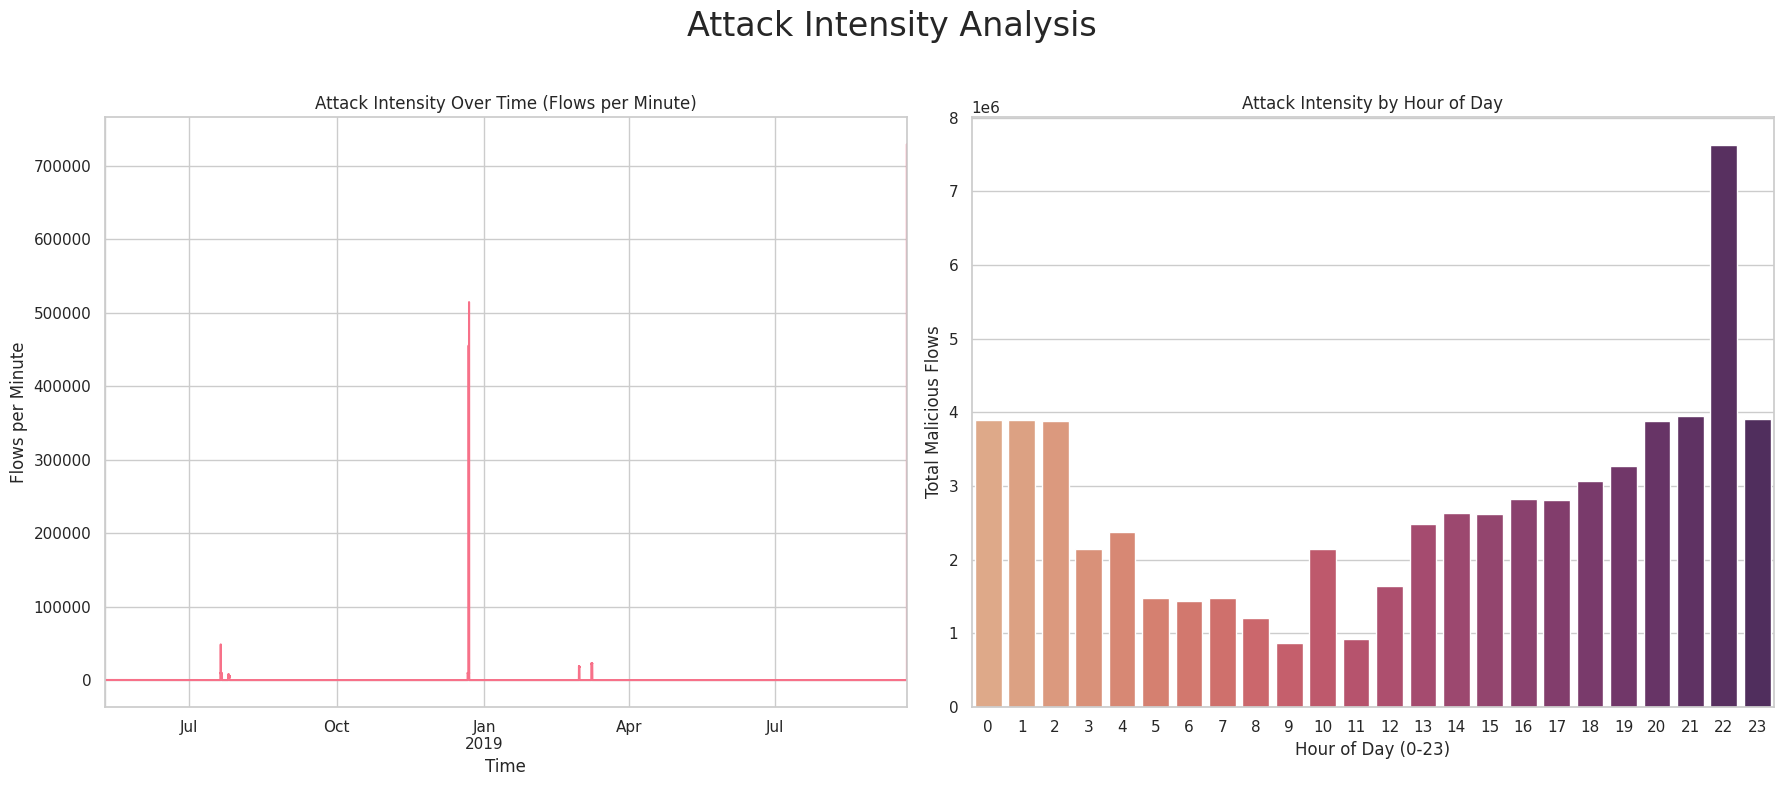


EDA 6 Complete.


In [ ]:
print("\n--- EDA 6: Attack Intensity Analysis (Optimized) ---")

# Create the figure and axes for our plots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Attack Intensity Analysis', fontsize=24)

#  Attack intensity over time plot
print("Generating Plot 1: Intensity Timeline...")
try:
    # Load only the two columns needed for this plot
    df_plot1 = pd.read_parquet(enriched_parquet_path, columns=['datetime', 'attack_phase'], engine='fastparquet')
    
    # Create the plot
    malicious_df = df_plot1[df_plot1['attack_phase'] != 'Normal_Activity']
    if not malicious_df.empty:
        intensity = malicious_df.set_index('datetime').resample('1min').size()
        intensity.plot(ax=axes[0])
        axes[0].set_title('Attack Intensity Over Time (Flows per Minute)')
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Flows per Minute')

finally:
    # Clean up memory
    if 'df_plot1' in locals(): del df_plot1
    if 'malicious_df' in locals(): del malicious_df
    gc.collect()
    print("Memory cleared for Plot 1.")


# Peak attack periods by hour Plot
print("\nGenerating Plot 2: Hourly Intensity...")
try:
    #: Load only the two columns needed for this plot
    df_plot2 = pd.read_parquet(enriched_parquet_path, columns=['hour', 'attack_phase'], engine='fastparquet')
    
    #: Create the plot
    malicious_df = df_plot2[df_plot2['attack_phase'] != 'Normal_Activity']
    if not malicious_df.empty:
        hourly_intensity = malicious_df.groupby('hour').size()
        sns.barplot(x=hourly_intensity.index, y=hourly_intensity.values, ax=axes[1], palette='flare')
        axes[1].set_title('Attack Intensity by Hour of Day')
        axes[1].set_xlabel('Hour of Day (0-23)')
        axes[1].set_ylabel('Total Malicious Flows')

finally:
    #: Clean up memory
    if 'df_plot2' in locals(): del df_plot2
    if 'malicious_df' in locals(): del malicious_df
    gc.collect()
    print("Memory cleared for Plot 2.")


# Finalize and Save 
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(RESULTS_DIR / 'eda_6_attack_intensity.png', dpi=300)
plt.show()

print("\nEDA 6 Complete.")

### Protocol Usage Analysis Plots


--- EDA 7: Protocol Usage Analysis ---
Generating Plot 1: Overall Protocol Distribution...
Memory cleared for Plot 1.

Generating Plot 2: Protocol Usage by Attack Phase...
Memory cleared for Plot 2.


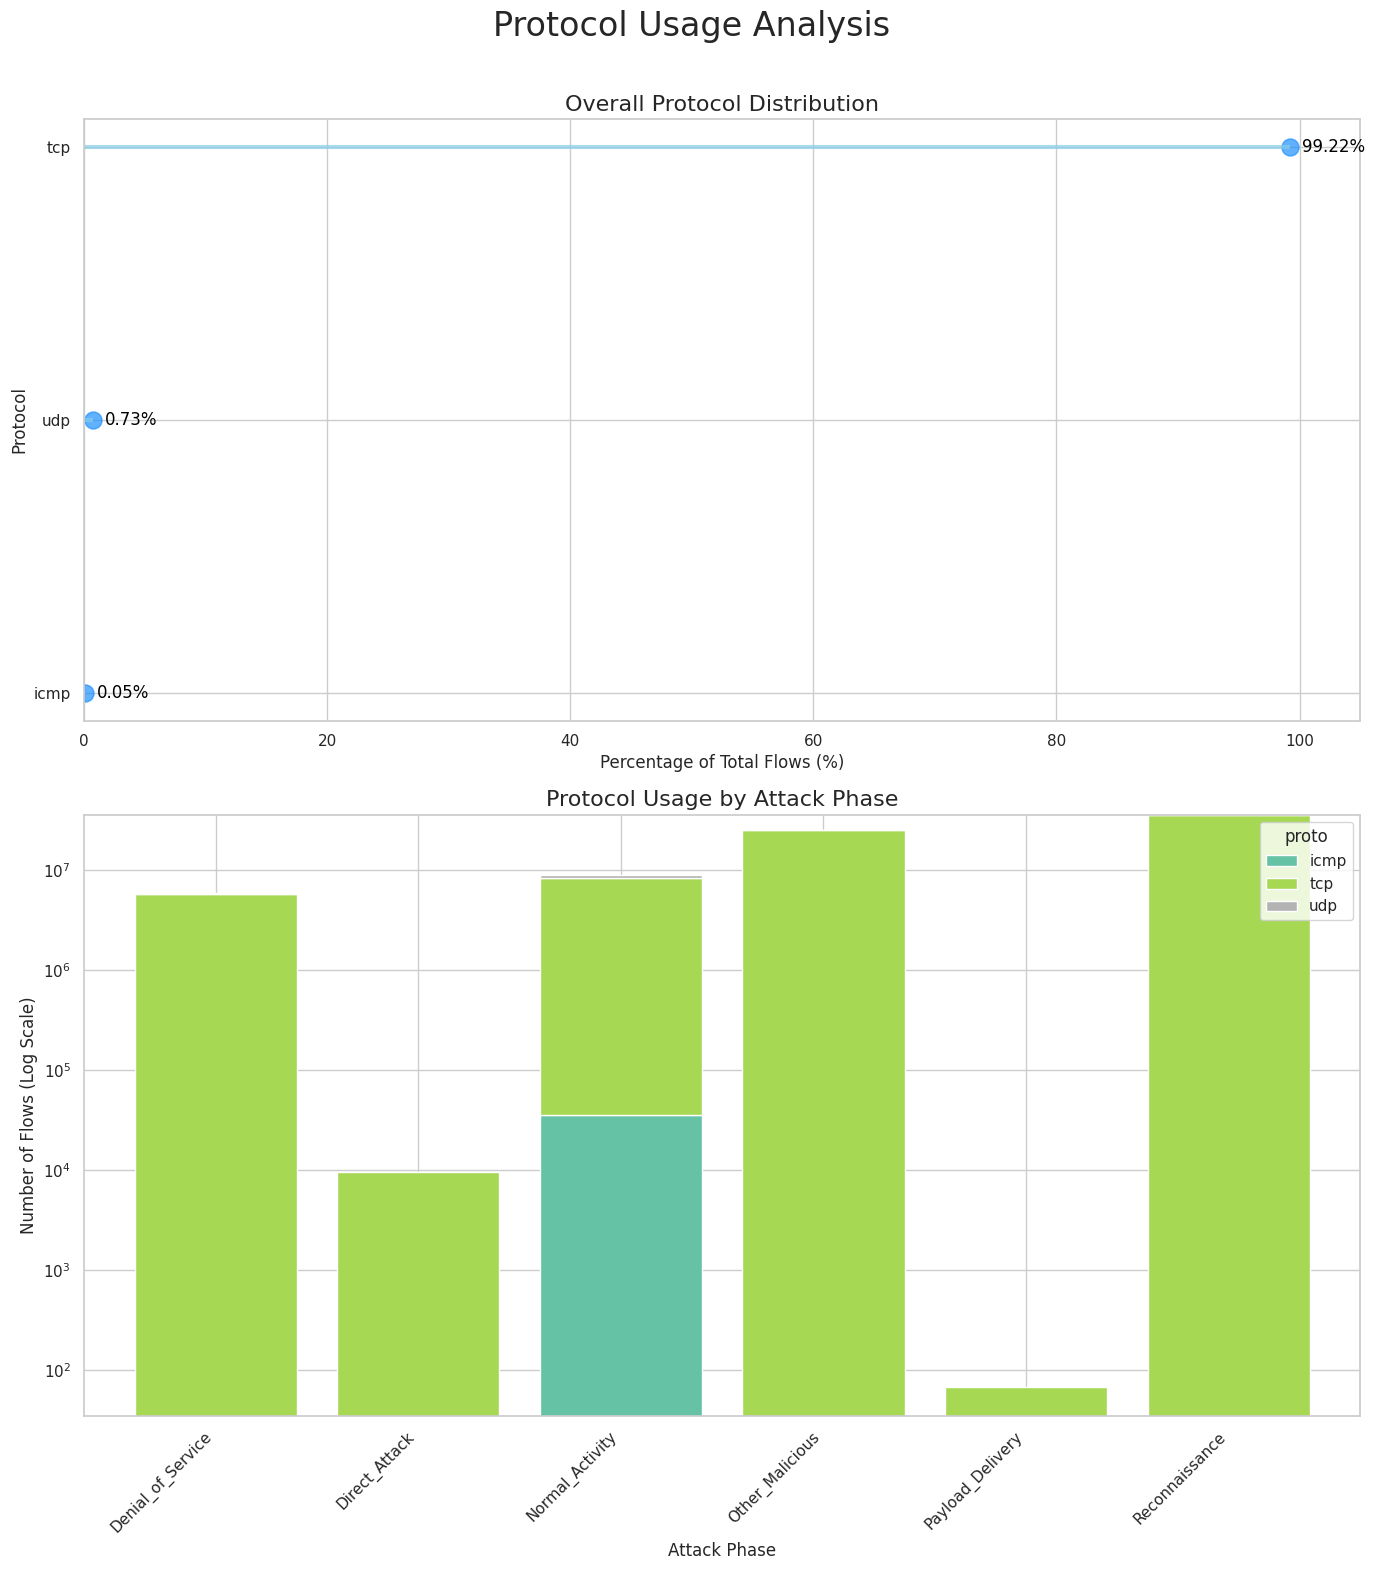


EDA 7 Complete.


In [ ]:
print("\n--- EDA 7: Protocol Usage Analysis ---")

# Creating a single figure with a 2x1 grid 
fig, axes = plt.subplots(2, 1, figsize=(14, 16)) 
fig.suptitle('Protocol Usage Analysis', fontsize=24)


# Overall protocol distribution Plot
print("Generating Plot 1: Overall Protocol Distribution...")
try:
    df_plot1 = pd.read_parquet(enriched_parquet_path, columns=['proto'], engine='fastparquet')
    
    proto_counts = df_plot1['proto'].value_counts()
    proto_proportions = (proto_counts / len(df_plot1)) * 100
    proto_proportions = proto_proportions.sort_values()
    
    # Draw the plot on the first subplot 
    axes[0].hlines(
        y=proto_proportions.index, xmin=0, xmax=proto_proportions.values,
        color='skyblue', alpha=0.7, linewidth=3
    )
    axes[0].scatter(
        proto_proportions.values, proto_proportions.index,
        color='dodgerblue', alpha=0.7, s=150
    )

    for i, v in enumerate(proto_proportions.values):
        axes[0].text(v + 1, i, f'{v:.2f}%', color='black', va='center')

    axes[0].set_title('Overall Protocol Distribution', fontsize=16)
    axes[0].set_xlabel('Percentage of Total Flows (%)', fontsize=12)
    axes[0].set_ylabel('Protocol', fontsize=12)
    axes[0].set_xlim(0, 105)

finally:
    if 'df_plot1' in locals(): del df_plot1
    if 'proto_counts' in locals(): del proto_counts
    if 'proto_proportions' in locals(): del proto_proportions
    gc.collect()
    print("Memory cleared for Plot 1.")


# Protocol usage by attack phase Plot
print("\nGenerating Plot 2: Protocol Usage by Attack Phase...")
try:
    df_plot2 = pd.read_parquet(enriched_parquet_path, columns=['attack_phase', 'proto'], engine='fastparquet')
    
    proto_phase_crosstab = pd.crosstab(df_plot2['attack_phase'], df_plot2['proto'])
    
    # Draw the plot on the second subplot
    proto_phase_crosstab.plot(kind='bar', stacked=True, ax=axes[1], colormap='Set2', width=0.8)
    axes[1].set_title('Protocol Usage by Attack Phase', fontsize=16)
    axes[1].set_xlabel('Attack Phase', fontsize=12)
    axes[1].set_ylabel('Number of Flows (Log Scale)', fontsize=12)
    axes[1].set_yscale('log')
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')

finally:
    if 'df_plot2' in locals(): del df_plot2
    gc.collect()
    print("Memory cleared for Plot 2.")


# Finalize and Save the combined figure
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(RESULTS_DIR / 'eda_7_protocol_analysis_combined.png', dpi=300)
plt.show()

print("\nEDA 7 Complete.")

### Attack Target and Source Analysis Plots


--- EDA 8: Attack Target and Source Analysis (Maximally Optimized) ---
Generating Plot 1: Most Targeted Hosts...
Memory cleared for Plot 1.

Generating Plot 2: Top Attack Sources...
Memory cleared for Plot 2.


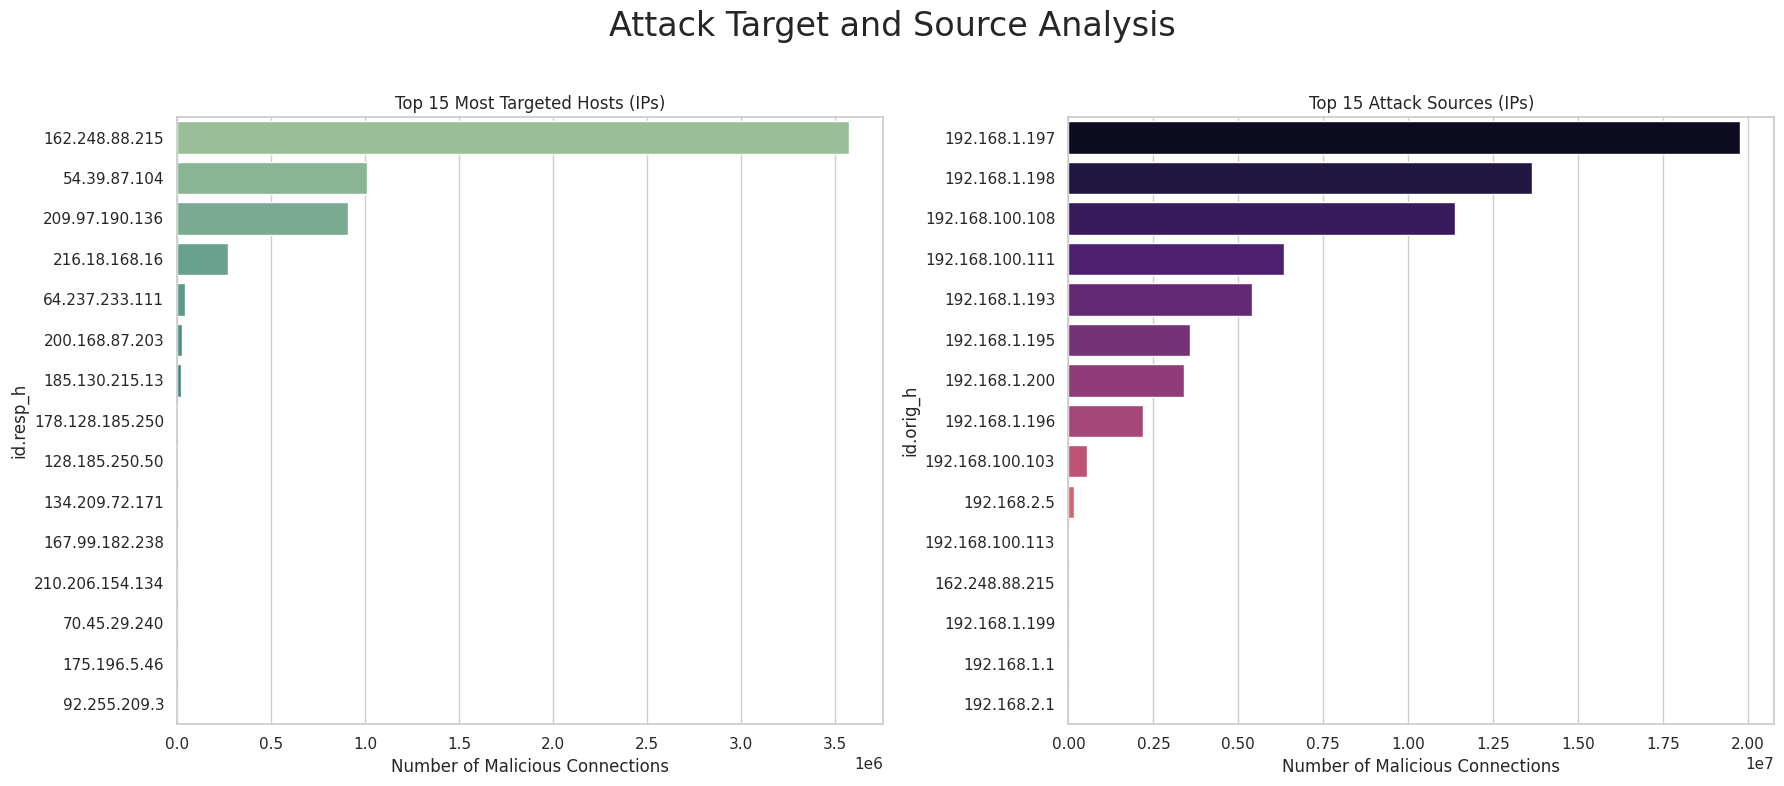


EDA 8 Complete.


In [ ]:
print("\n--- EDA 8: Attack Target and Source Analysis (Maximally Optimized) ---")

# Create the figure and axes for our plots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Attack Target and Source Analysis', fontsize=24)

#  Most targeted hosts Plot
print("Generating Plot 1: Most Targeted Hosts...")
try:
    # Load only 'id.resp_h' and 'attack_phase'
    df_plot1 = pd.read_parquet(enriched_parquet_path, columns=['id.resp_h', 'attack_phase'], engine='fastparquet')
    
    # Filter to malicious traffic and get value counts directly
    target_counts = df_plot1[df_plot1['attack_phase'] != 'Normal_Activity']['id.resp_h'].value_counts().head(15)
    
    # Create the plot
    sns.barplot(y=target_counts.index, x=target_counts.values, ax=axes[0], orient='h', palette='crest')
    axes[0].set_title('Top 15 Most Targeted Hosts (IPs)')
    axes[0].set_xlabel('Number of Malicious Connections')

finally:
    # Clean up memory
    if 'df_plot1' in locals(): del df_plot1
    if 'target_counts' in locals(): del target_counts
    gc.collect()
    print("Memory cleared for Plot 1.")


# Top attack sources Plot
print("\nGenerating Plot 2: Top Attack Sources...")
try:
    # Load only 'id.orig_h' and 'attack_phase'
    df_plot2 = pd.read_parquet(enriched_parquet_path, columns=['id.orig_h', 'attack_phase'], engine='fastparquet')
    
    # Filter to malicious traffic and get value counts directly
    source_counts = df_plot2[df_plot2['attack_phase'] != 'Normal_Activity']['id.orig_h'].value_counts().head(15)
    
    # Create the plot
    sns.barplot(y=source_counts.index, x=source_counts.values, ax=axes[1], orient='h', palette='magma')
    axes[1].set_title('Top 15 Attack Sources (IPs)')
    axes[1].set_xlabel('Number of Malicious Connections')

finally:
    # Clean up memory
    if 'df_plot2' in locals(): del df_plot2
    if 'source_counts' in locals(): del source_counts
    gc.collect()
    print("Memory cleared for Plot 2.")


# Finalize and Save 
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(RESULTS_DIR / 'eda_8_target_analysis.png', dpi=300)
plt.show()

print("\nEDA 8 Complete.")

### Attack Correlation Analysis Plot


--- EDA 9: Attack Correlation Analysis (Corrected & Reliable) ---
Loading data for EDA 9...
Data loaded successfully.
Sampled 50000 rows for plotting.


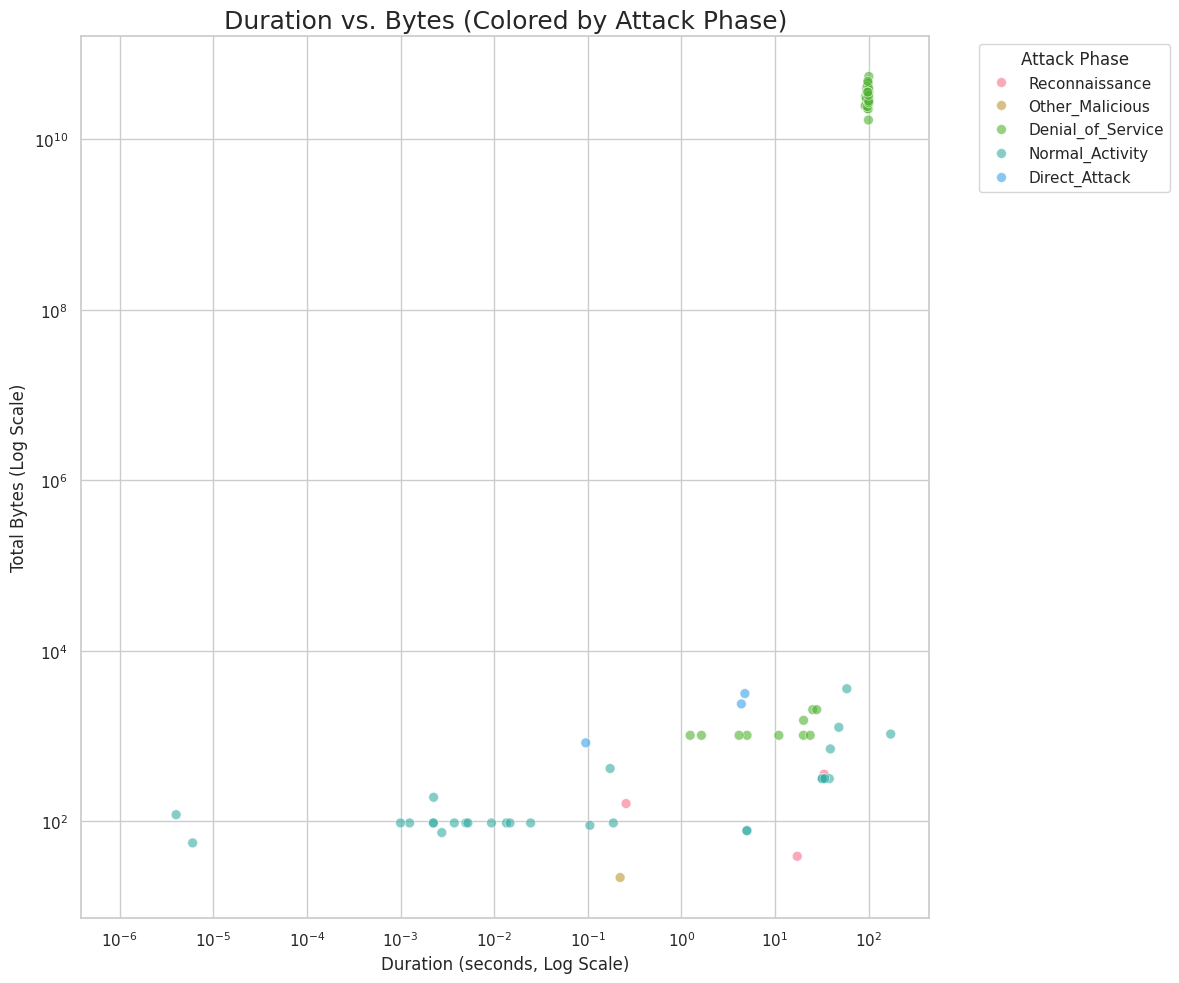


Cleared EDA 9 DataFrames from memory.


In [ ]:
print("\n--- EDA 9: Attack Correlation Analysis (Corrected & Reliable) ---")

# Define ONLY the columns needed
columns_needed = ['duration', 'total_bytes', 'attack_phase']
sample_size = 50000 

# Loading ONLY the required data into memory
print("Loading data for EDA 9...")
try:
    # Loading only the specified columns. This is efficient.
    eda_df = pd.read_parquet(enriched_parquet_path, columns=columns_needed, engine='fastparquet')
    print("Data loaded successfully.")

    sample_df = eda_df.sample(n=min(sample_size, len(eda_df)), random_state=42) 
    
    # Explicitly clear the full eda_df from memory after sampling
    del eda_df
    gc.collect()
    print(f"Sampled {len(sample_df)} rows for plotting.")

    # Create the plot
    plt.figure(figsize=(12, 10))
    
    ax = sns.scatterplot(data=sample_df, x='duration', y='total_bytes', hue='attack_phase', alpha=0.6, s=50)
    ax.set_xlabel('Duration (seconds, Log Scale)')
    ax.set_ylabel('Total Bytes (Log Scale)')
    ax.set_title('Duration vs. Bytes (Colored by Attack Phase)', fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(title='Attack Phase', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'eda_9_correlation_analysis.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"An error occurred during plotting: {e}")

finally:
    # Final clean up memory immediately
    if 'sample_df' in locals():
        del sample_df
    if 'eda_df' in locals():
        del eda_df
    gc.collect()
    print("\nCleared EDA 9 DataFrames from memory.")

### Attack Signature Identification Plots


--- EDA 10: Attack Signature Identification (Optimized) ---
Generating Plot 1: Port Signatures (Bubble Chart)...


Memory cleared for Plot 1.
Memory cleared for Plot 2.
Memory cleared for Plot 3.
Memory cleared for Plot 4.


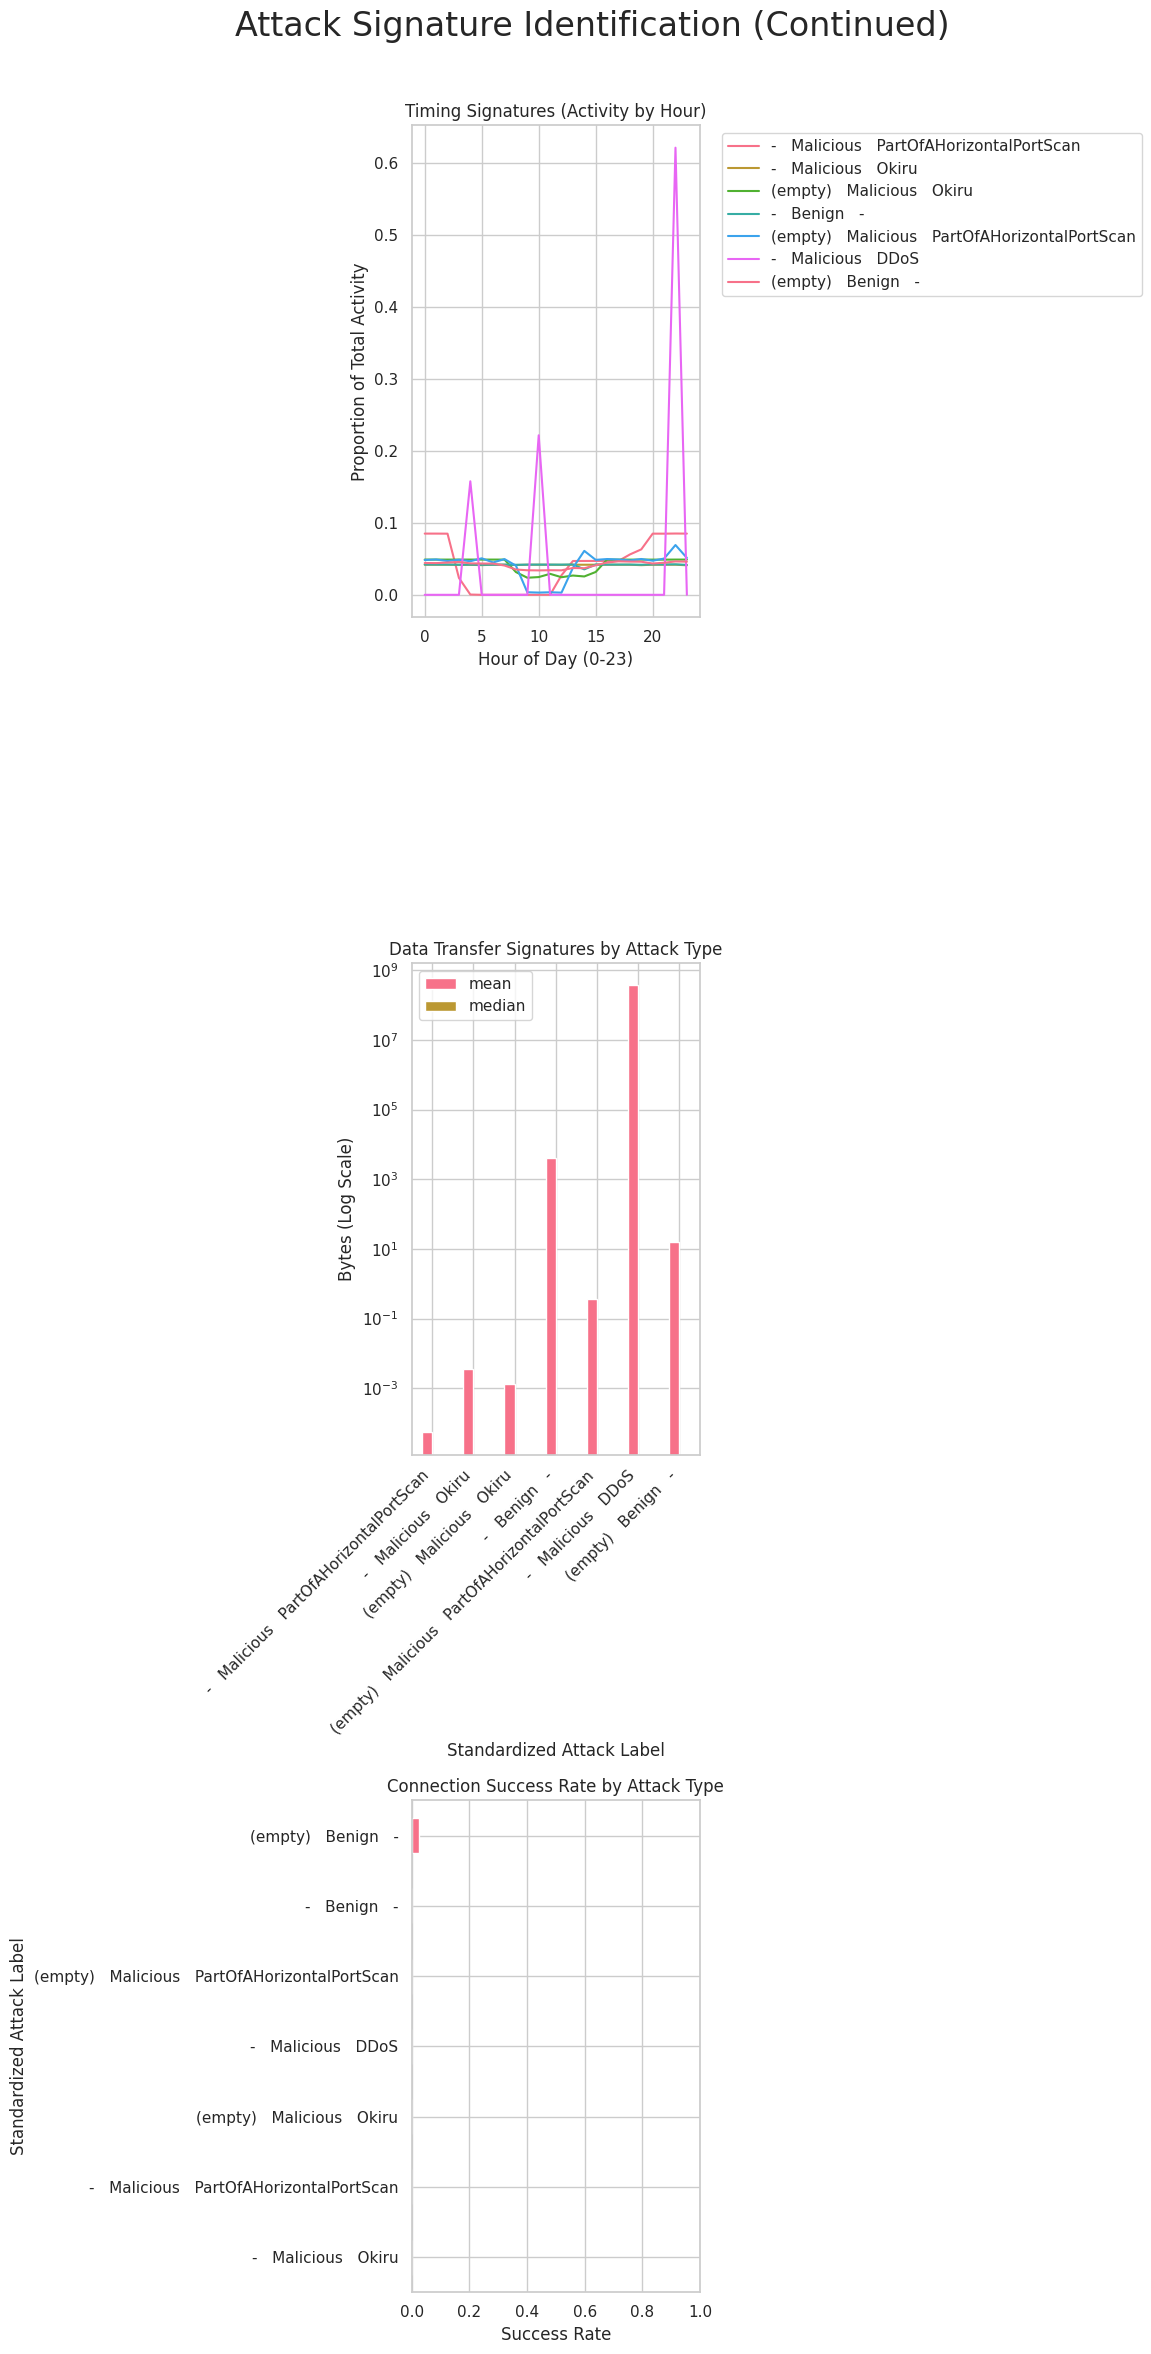


EDA 10 Complete.


In [4]:
print("\n--- EDA 10: Attack Signature Identification (Optimized) ---")

# Port signatures by attack type Plot
print("Generating Plot 1: Port Signatures (Bubble Chart)...")
try:
    import plotly.express as px
    df_plot1 = pd.read_parquet(enriched_parquet_path, columns=['id.resp_p', 'standardized_label'], engine='fastparquet')
    
    df_plot1['standardized_label'].fillna('Unknown', inplace=True)
    df_plot1['standardized_label'] = df_plot1['standardized_label'].astype(str)
    malicious_df_plot1 = df_plot1[
        (df_plot1['standardized_label'] != 'Benign') & 
        (df_plot1['standardized_label'] != 'Unknown')
    ].copy()

    if malicious_df_plot1.empty:
        print("  - No malicious data for Plot 1. Skipping.")
    else:
        agg_df = malicious_df_plot1.groupby(['standardized_label', 'id.resp_p']).size().reset_index(name='count')
        
        fig1 = px.scatter(
            agg_df, x="id.resp_p", y="standardized_label",
            size="count", color="count", hover_name="standardized_label",
            hover_data={'count': ':,', 'id.resp_p': True},
            size_max=60, title="Port Signatures for Malicious Attack Types (Bubble Size = Count)",
            labels={"id.resp_p": "Port Number", "standardized_label": "Standardized Attack Label", "count": "Connections"},
            color_continuous_scale='Reds', height=700
        )
        fig1.update_xaxes(type='category')
        fig1.show()
        fig1.write_html(RESULTS_DIR / 'eda_10_plot1_port_signatures_bubble.html')
        fig1.write_image(RESULTS_DIR / 'eda_10_plot1_port_signatures_bubble.png')
finally:
    if 'df_plot1' in locals(): del df_plot1
    if 'malicious_df_plot1' in locals(): del malicious_df_plot1
    if 'agg_df' in locals(): del agg_df
    gc.collect()
    print("Memory cleared for Plot 1.")


# Create a single figure with a 3x1 grid of subplots 
fig, axes = plt.subplots(3, 1, figsize=(12, 24)) 
fig.suptitle('Attack Signature Identification (Continued)', fontsize=24)

# Timing signatures by attack type Plot
try:
    df_plot2 = pd.read_parquet(enriched_parquet_path, columns=['hour', 'standardized_label'], engine='fastparquet')
    malicious_df_plot2 = df_plot2[df_plot2['standardized_label'] != 'Benign']
    top_malicious_labels = malicious_df_plot2['standardized_label'].value_counts().head(7).index 
    timing_signatures = pd.crosstab(malicious_df_plot2['hour'], malicious_df_plot2['standardized_label'])
    timing_signatures_norm = timing_signatures.div(timing_signatures.sum(axis=0), axis=1)
    
    timing_signatures_norm[top_malicious_labels].plot(ax=axes[0])
    axes[0].set_title('Timing Signatures (Activity by Hour)')
    axes[0].set_xlabel('Hour of Day (0-23)')
    axes[0].set_ylabel('Proportion of Total Activity')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
finally:
    if 'df_plot2' in locals(): del df_plot2
    if 'malicious_df_plot2' in locals(): del malicious_df_plot2
    gc.collect()
    print("Memory cleared for Plot 2.")


# Data transfer signatures Plot
try:
    df_plot3 = pd.read_parquet(enriched_parquet_path, columns=['total_bytes', 'standardized_label'], engine='fastparquet')
    malicious_df_plot3 = df_plot3[df_plot3['standardized_label'] != 'Benign']
    top_malicious_labels = malicious_df_plot3['standardized_label'].value_counts().head(7).index
    transfer_signatures = malicious_df_plot3.groupby('standardized_label')['total_bytes'].agg(['mean', 'median'])
    transfer_signatures = transfer_signatures.loc[top_malicious_labels]
    
    transfer_signatures[['mean', 'median']].plot(kind='bar', ax=axes[1], logy=True) 
    axes[1].set_title('Data Transfer Signatures by Attack Type')
    axes[1].set_xlabel('Standardized Attack Label')
    axes[1].set_ylabel('Bytes (Log Scale)')
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right")
finally:
    if 'df_plot3' in locals(): del df_plot3
    if 'malicious_df_plot3' in locals(): del malicious_df_plot3
    gc.collect()
    print("Memory cleared for Plot 3.")


# Connection success signatures Plot
try:
    df_plot4 = pd.read_parquet(enriched_parquet_path, columns=['connection_successful', 'standardized_label'], engine='fastparquet')
    malicious_df_plot4 = df_plot4[df_plot4['standardized_label'] != 'Benign']
    top_malicious_labels = malicious_df_plot4['standardized_label'].value_counts().head(7).index
    success_signatures = malicious_df_plot4.groupby('standardized_label')['connection_successful'].mean()
    success_signatures = success_signatures.loc[top_malicious_labels]
    
    success_signatures.sort_values().plot(kind='barh', ax=axes[2]) 
    axes[2].set_title('Connection Success Rate by Attack Type')
    axes[2].set_xlabel('Success Rate')
    axes[2].set_ylabel('Standardized Attack Label')
    axes[2].set_xlim(0, 1)
finally:
    if 'df_plot4' in locals(): del df_plot4
    if 'malicious_df_plot4' in locals(): del malicious_df_plot4
    gc.collect()
    print("Memory cleared for Plot 4.")


# Finalize and Save the static plot grid 
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(RESULTS_DIR / 'eda_10_other_signatures.png', dpi=300)
plt.show()

print("\nEDA 10 Complete.")